## packages install

In [1]:
# !pip3 install torch torchvision torchaudio --extra-index-url https: // download.pytorch.org / whl / cpu
# !pip install -U matplotlib

## imports

In [2]:
import os
import sys

import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from torch import tensor, Tensor
from torch.nn import functional
import pandas as pd

sys.path.append(os.path.abspath(r'../../'))

from src.config import PATH_SAVE_MODELS, PATH_DATASETS
from src.utils.common import get_loader, get_device
from src.utils.dataset import GPUDataset, get_cifar
from src.utils.plot import plot_prune_example, plot_img_and_top
from src.utils.train import Mode, ModelManager

# globals
NUM_CLASSES = 100
BATCH_SIZE = 25
NUM_TRAIN = 50000
NUM_TEST = 10000
ENSEMBLE_SIZE = 10
ENSEMBLE_EPOCHS = 2  # ~ 26.1%

ENSAMBLE_SAVED_DATA = os.path.join(PATH_SAVE_MODELS, 'el2n', 'general.pt')
DEVICE = get_device()

train_idx = np.arange(NUM_TRAIN, dtype=int)
test_idx = np.arange(NUM_TEST, dtype=int)
dataset_train, dataset_test, dataset_train_ordered, dataset_train_raw = get_cifar(PATH_DATASETS)
loader_train = get_loader(dataset_train, train_idx, BATCH_SIZE)
loader_test = get_loader(dataset_test, test_idx, BATCH_SIZE, False)
loader_train_ordered = get_loader(dataset_train_ordered, train_idx, BATCH_SIZE, False)
Y_train = Tensor(dataset_train.targets)[train_idx].type(torch.int64)
Y_test = Tensor(dataset_test.targets)[test_idx].type(torch.int64)

CUDA is available!  Training on  GPU...
Files already downloaded and verified
Files already downloaded and verified


In [3]:
def get_el2n_scores(y: tensor, ensemble_pred: tensor):
    """
    calculate mean on the L2 over ensemble of algorithms

    :param y: labels, shape: (data len)
    :param ensemble_pred: scores for every data example, shape: (ensemble size, data len, labels len)

    :return: el2n_scores: vector of scores how the example hard to learn for every data
             shape: (data len)
    """
    y_one_hot = torch.nn.functional.one_hot(y, num_classes=ensemble_pred.shape[-1])
    return torch.mean(torch.linalg.norm(y_one_hot - ensemble_pred, ord=2, dim=2), dim=0)

In [22]:
ensemble: list[ModelManager] = [ModelManager(NUM_CLASSES, f'ensemble_{i}', 'el2n', True) for i in
                                range(ENSEMBLE_SIZE)]
ensemble_softmax = torch.empty((len(ensemble), NUM_TRAIN, NUM_CLASSES))
ensemble_pred = torch.empty((NUM_TRAIN, len(ensemble)), dtype=torch.bool)

print()
for i, model_manager in enumerate(ensemble):
    print(f'------------   model {i}   -------------------')
    model_manager.train(loader_train, loader_test, loader_test, 1)
    model_manager.model.cuda()
    scores, pred, loss, acc = model_manager.run_epoch(loader_train_ordered, mode=Mode.TEST)
    pred = pred.cpu()
    scores = scores.cpu()
    ensemble_softmax[i] = functional.softmax(scores, dim=1)
    ensemble_pred[:, i] = torch.Tensor(pred.type(torch.int8) == Y_train)  #.clone().detach().cpu()

ensemble_pred_sum = torch.sum(ensemble_pred, dim=1)
ensemble_std = ensemble_softmax.std(dim=0)
el2n_scores = get_el2n_scores(Y_train, ensemble_softmax)

torch.save(
    {'ensemble_softmax': ensemble_softmax, 'ensemble_pred': ensemble_pred, 'ensemble_pred_sum': ensemble_pred_sum,
     'ensemble_std': ensemble_std, 'el2n_scores': el2n_scores},
    ENSAMBLE_SAVED_DATA)


------------   model 0   -------------------
Epoch: 2 Training: Loss: 0.117851 Acc: 0.258360  Validation Loss: 0.108294 Acc: 0.306900                                                    
Validation loss decreased (0.119016 --> 0.108294).  Saving model to models_data/el2n\ensemble_0
Test Loss: 0.108294                                                                                                                     
Accuracy: 0.30689999999999995
------------   model 1   -------------------                                                                                              
Epoch: 2 Training: Loss: 0.116995 Acc: 0.261100  Validation Loss: 0.114089 Acc: 0.292700                                                    
Validation loss decreased (0.122782 --> 0.114089).  Saving model to models_data/el2n\ensemble_1
Test Loss: 0.114089                                                                                                                     
Accuracy: 0.29270000000000046
-------

In [23]:
data = torch.load(ENSAMBLE_SAVED_DATA)

ensemble_softmax = data['ensemble_softmax']
ensemble_pred = data['ensemble_pred']
ensemble_pred_sum = data['ensemble_pred_sum']
ensemble_std = data['ensemble_std']
el2n_scores = data['el2n_scores']

In [24]:
# print(ensemble_softmax[:, 0, :])
# print(ensemble_pred[0])
# print(Y_train[0])
print(el2n_scores[0])
x = el2n_scores[0]
y_hot = torch.nn.functional.one_hot(Y_train[0], num_classes=NUM_CLASSES)
# print(y_hot)
print(((((y_hot - ensemble_softmax[:, 0, :]) ** 2).sum(dim=1)) ** .5).mean())

tensor(1.0135)
tensor(1.0135)


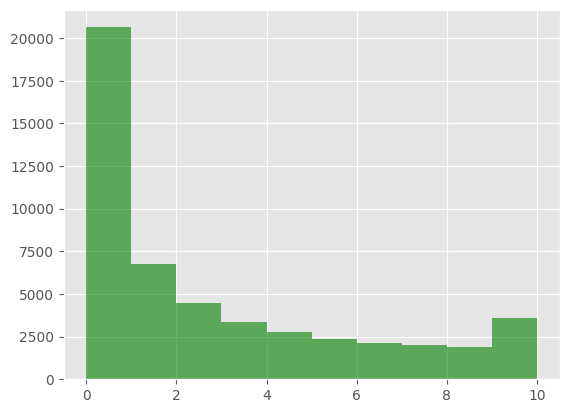

In [7]:
plt.style.use('ggplot')
# plt.figure(figsize=(10, 4))
plt.hist(ensemble_pred_sum, bins=ENSEMBLE_SIZE, facecolor='g', alpha=0.6)
plt.show()

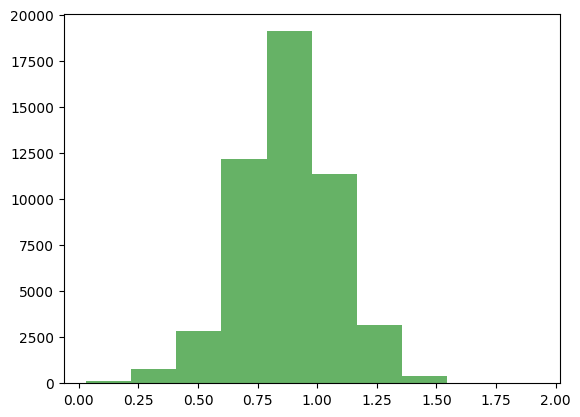

In [25]:
plt.hist(ensemble_std.sum(dim=1), facecolor='g', alpha=0.6)
plt.show()

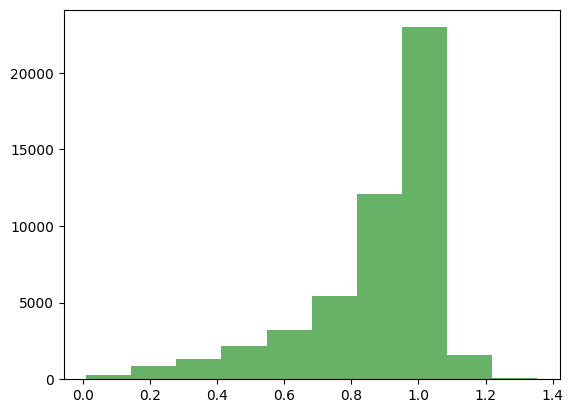

In [26]:
plt.hist(el2n_scores, bins=ENSEMBLE_SIZE, facecolor='g', alpha=0.6)
plt.show()

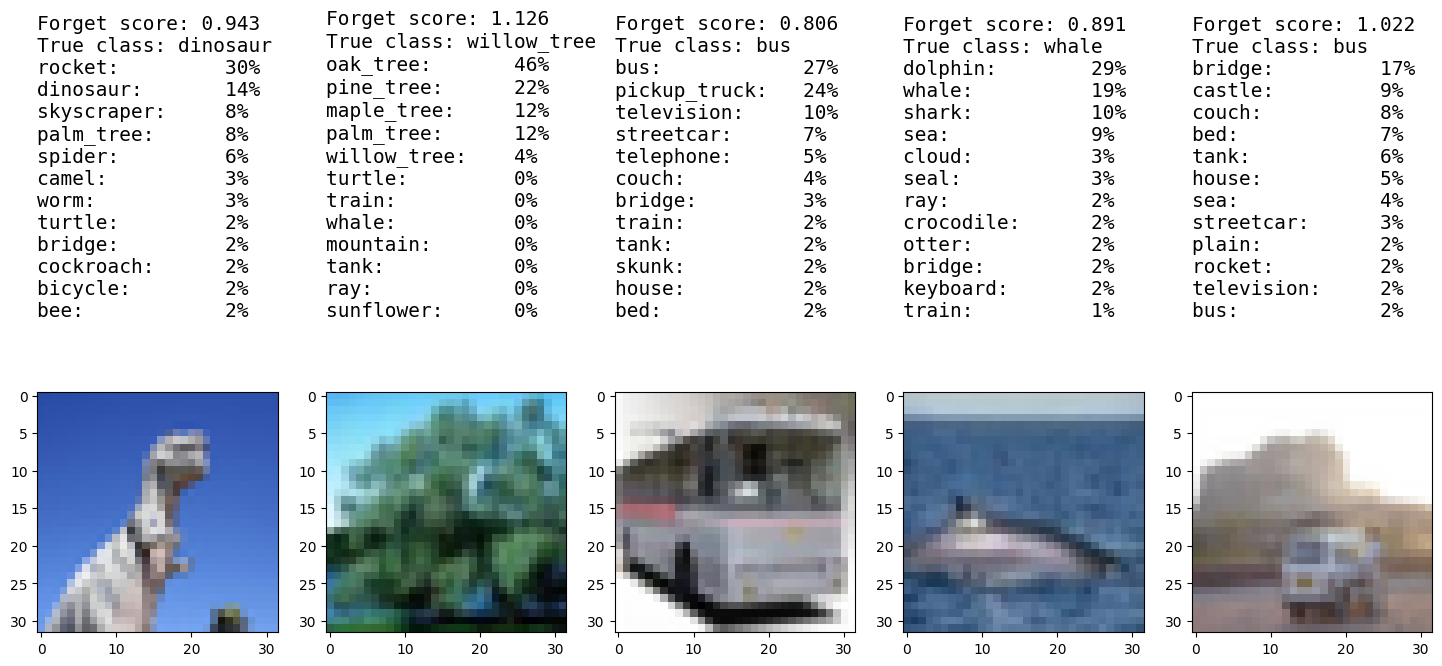

In [28]:
data_train_raw = torchvision.datasets.CIFAR10(os.path.abspath(r'../../../datasets'), train=True)
plot_img_and_top(dataset_train_raw, (.0, .99), el2n_scores, ensemble_softmax, ensemble=True, score_name='Forget')

# plot_prune_example(data_train_raw, el2n_scores, hardest=True, prune_method_name='EL2N', random=False)
# plot_prune_example(data_train_raw, el2n_scores, hardest=False, prune_method_name='EL2N', random=False)

In [11]:
# dataset_train, dataset_test = get_cifar(PATH_DATASETS)
# loader_test = get_loader(dataset_test, np.arange(NUM_TEST), BATCH_SIZE, False)
# # remove 1% the hardest examples
# NUM_TRAIN = int(NUM_TRAIN * .99)
# idx_sorted_to_train = el2n_scores.sort()[1].numpy()[:NUM_TRAIN]

In [29]:
def pred_ensamble(ensemble_, loader, Y):
    len_dataset = len(loader.dataset)

    en_scores = torch.empty((len(ensemble_), len_dataset, NUM_CLASSES))
    en_pred = torch.empty((len(ensemble_), len_dataset))

    for model_manager_ in ensemble_:
        model_manager.model.cuda()
        scores_, pred_, loss_, acc_ = model_manager_.run_epoch(loader, mode=Mode.TEST)
        en_scores[i] = scores_.cpu()
        en_pred[i] = torch.Tensor(pred_.cpu().type(torch.int8) == Y)

    scores_mean = en_scores.mean(dim=0)
    pred_mean = torch.max(scores_mean, 1)[1]
    acc_ = torch.sum(pred_mean.eq(Y)).item() / len_dataset

    print(acc_)


pred_ensamble(ensemble, loader_test, Y_test)

0.311                                                                                                                                   


# 1. every 2 epochs add the next group of hard to dataset

In [13]:
# model_manager = ModelManager(NUM_CLASSES, 'el2n_simple_to_hard', load=False)
#
# print()
# idx = np.array([], dtype=int)
# for subset in np.array_split(idx_sorted_to_train, 10):
#     print(f'====     Train on {(len(idx) + len(subset)) / NUM_TRAIN:.0%} simplest     ======')
#     loader_train = get_loader(dataset_train, idx := np.append(idx, subset), BATCH_SIZE, True)
#     model_manager.train(loader_train, loader_test, loader_test, 3)
#
#     print()

# 2. same as 1 but remove 50% of last group

In [14]:
# model_manager = ModelManager(NUM_CLASSES, 'el2n_simple_to_hard_50p', load=False)
#
# print()
# idx = np.array([], dtype=int)
# for subset in np.array_split(idx_sorted_to_train, 10):
#     print(f'====    Train on {(len(idx) + len(subset)) / NUM_TRAIN:.0%} simplest     ======')
#
#     loader_train = get_loader(dataset_train, np.append(idx, subset), BATCH_SIZE, True)
#     model_manager.train(loader_train, loader_test, loader_test, 3)
#
#     idx = np.append(idx, np.random.choice(subset, len(subset) // 2, replace=False))
#
#     print()

# 3. train only 50% of the simplest examples

In [15]:
# model_manager = ModelManager(NUM_CLASSES, 'el2n_easiest', load=False)
#
# loader_train = get_loader(dataset_train, idx_sorted_to_train[:NUM_TRAIN // 2], BATCH_SIZE, True)
# print()
# model_manager.train(loader_train, loader_test, loader_test, EPOCHS)

# 4. train 9 models each with 10% less easy train examples

In [16]:
# models = []
#
# print()
# loss, acc, prune_size = [], [], []
# idx = np.array([], dtype=int)
#
# for subset in np.array_split(idx_sorted_to_train, 10):
#     idx = np.append(idx, subset)
#     prcent = len(idx) / NUM_TRAIN
#     print(f'====     train model with {prcent:.0%} most hard     ======')
#     loader_train = get_loader(dataset_train, idx, BATCH_SIZE, True)
#
#     model_manager = ModelManager(NUM_CLASSES, f'el2n_{int(prcent * 100)}p_hard', dir_='el2n_p_hard', load=False)
#     model_manager.train(loader_train, loader_test, loader_test, EPOCHS)
#
#     models.append(model_manager)
#     prune_size.append(prcent), acc.append(model_manager.data['test']['acc']), loss.append(
#         model_manager.data['test']['loss'])
#     print()
#
# ModelManager.save_models_log(models, 'el2n_p_hard')

In [17]:
# fig, axes = plt.subplots(1, 2, figsize=(17, 4))
# axes[0].plot(prune_size, loss)
# axes[0].set_xlabel('prune size')
# axes[0].set_ylabel('Loss')
# axes[1].plot(prune_size, acc)
# axes[1].set_xlabel('prune size')
# axes[1].set_ylabel('Acc')
# fig.subplots_adjust(wspace=.4)
# plt.plot()

# 5.

In [18]:
# models = []
#
# print()
# loss, acc, prune_size = [], [], []
# idx = np.array([], dtype=int)
#
# for subset in np.array_split(idx_sorted_to_train[::-1], 10):
#     idx = np.append(idx, subset)
#     prcent = len(idx) / NUM_TRAIN
#     print(f'====     train model with {prcent:.0%} most hard     ======')
#     loader_train = get_loader(dataset_train, idx, BATCH_SIZE, True)
#
#     model_manager = ModelManager(NUM_CLASSES, f'el2n_{int(prcent * 100)}p_hard_', dir_='el2n_p_hard_', load=False)
#     model_manager.train(loader_train, loader_test, loader_test, EPOCHS)
#
#     models.append(model_manager)
#     prune_size.append(prcent), acc.append(model_manager.data['test']['acc']), loss.append(
#         model_manager.data['test']['loss'])
#     print()
#
# ModelManager.save_models_log(models, 'el2n_p_hard_')

In [19]:
# fig, axes = plt.subplots(1, 2, figsize=(17, 4))
# axes[0].plot(prune_size, loss)
# axes[0].set_xlabel('prune size')
# axes[0].set_ylabel('Loss')
# axes[1].plot(prune_size, acc)
# axes[1].set_xlabel('prune size')
# axes[1].set_ylabel('Acc')
# fig.subplots_adjust(wspace=.4)
# plt.plot()

In [20]:
# E, T, C = 2, 3, 4
# s = np.arange(E * T * C, dtype=float).reshape((E, T, C))
# print(torch.from_numpy(s).mean(dim=0))